In [12]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math
import scipy.stats as stats


import import_ipynb
from CustomDataset import ControlsDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
torch.cuda.empty_cache()
print('using device', device)


using device cpu


In [13]:
dataset = ControlsDataset()
dataset.labels.num_categories = 21
dataset.labels.transform.categorize(1.05, -1.05, 21)
dataset.labels.infotype = "Category"
dataset.make_dataloaders()

Total training stacks 44
Total validation stacks 11


In [14]:
len(dataset)

1100

In [15]:
import torchvision.models as models
resnet50 = models.resnet50(pretrained=True)

In [16]:
resnet50 = models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad = False

resnet50.fc = nn.Sequential(nn.Linear(2048, 21))

resnet50 = resnet50.to(device)

In [17]:
counts = dataset.labels.dataframe.groupby('Category')['ID'].count()
counts = np.array(counts)
ratio = max(counts)/counts

In [18]:
A = np.ones((4,3))
B = np.arange(3)
print(B.shape)
print(A.shape)

R = np.multiply(B,A).T
print(R)

(3,)
(4, 3)
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]]


(20, 21)
(20, 1)


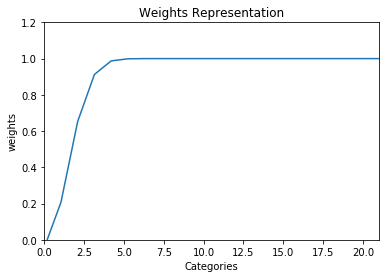

tensor([ 14.1481,  84.8889, 254.6667, 109.1429, 127.3333,  47.7500,  22.4706,
         20.1053,  16.6087,   8.8837,   1.0000,  34.7273, 191.0000,  63.6667])


In [19]:



batch_size = 20
index = 10
controls = np.arange(batch_size).reshape((batch_size,1))
mu = controls
variance = 2
sigma = np.sqrt(variance)
x = np.zeros((batch_size,21))
x[:] = np.linspace(0, 21, 21)
print(x.shape)
print(mu.shape)
pdf = stats.norm.pdf(x, mu, sigma)
maximum = 0.27
pdf = (maximum-pdf)/maximum

plt.xlim([0,21])
plt.ylim([0,1.2])
plt.plot(x[0], pdf[0])
plt.title("Weights Representation")
plt.xlabel("Categories")
plt.ylabel("weights")
plt.show()

weights = ratio
weights = torch.Tensor(weights).to(device)
print(weights)

In [20]:
epochs = 30
optimizer = optim.Adam(resnet50.parameters())
#criterion = nn.CrossEntropyLoss(weight=weights,reduction='none') # Changed from Mean-Squared to Cross-Entro

In [21]:
def score(model,device,dataset,single_batch = False):
    model.eval()
    total = 0
    correct = 0
    for i_batch, sampled_batch in enumerate(dataset.validloader):
        images = sampled_batch['image'].to(device).float()
        controls = sampled_batch['control'].to(device).long()
        controls = torch.flatten(controls)
        prediction = model(images)

        maximum = torch.argmax(prediction,dim = 1)
        shared = maximum == controls
        shared = 1 * shared
        correct += int(torch.sum(shared))
        total += len(controls)
        if single_batch:
            return (total,correct)
    return (total,correct)

In [23]:
from tqdm.notebook import tqdm_notebook
resnet50.train()
iter_no = 0
report_period = 20
percent = 0
for epoch in range(epochs):
    for i_batch, sampled_batch in tqdm_notebook(enumerate(dataset.dataloader),
                                                total=len(dataset.dataloader),
                                                desc= str(percent)):
        #inputs and forward pass
        images = sampled_batch['image'].to(device).float()
        controls = sampled_batch['control'].to(device).long()
        controls = torch.flatten(controls)

        #backwards pass
        optimizer.zero_grad()
        prediction = resnet50(images)
        #print(torch.argmax(prediction,dim=1))
        #print
        #print(controls)
        
        batch_size = 20
        index = 10
        mu = controls.reshape((batch_size,1))
        variance = 2
        sigma = np.sqrt(variance)
        x = np.zeros((batch_size,21))
        x[:] = np.linspace(0, 21, 21)
        #print(x.shape)
        #print(mu.shape)
        pdf = stats.norm.pdf(x, mu, sigma)
        maximum = 0.27
        inv = (maximum-pdf)/maximum
        inv = torch.Tensor(inv).to(device)
        
        prediction = torch.abs(prediction)
        
        #loss = criterion(prediction, controls)
        loss = torch.mean(prediction*inv)
        loss.backward()
        optimizer.step()

        iter_no += 1
        if iter_no % report_period == 0:
            #self.writer.add_scalar("Loss", loss.item(), iter_no)
            print("saved to tensorboard")
            #self.save(epoch,"snapshots/{:.3f}_model.pt".format(loss.item()))

    out = "{0},{1}\tLoss:{2}\tAllocated:{3}GB\tCached:{4}GB\n"
    print(out.format(str(epoch),
                    str(iter_no),
                    round(loss.item(),5),
                     'na', 'na'
                     #round(torch.cuda.memory_allocated(0)/1024**3,3),
                     #round(torch.cuda.memory_allocated(0)/1024**3,3)
                    ))
    epoch_score = score(resnet50,device,dataset,True)
    total,correct = epoch_score
    percent = round(epoch_score[1]/epoch_score[0],3)*100
    #print(correct)
    #print(prediction)
    print("Accuracy: {}%".format(correct/total*100))

saved to tensorboard
saved to tensorboard

0,44	Loss:0.05372	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

1,88	Loss:0.06356	Allocated:naGB	Cached:naGB

Accuracy: 15.0%


saved to tensorboard
saved to tensorboard

2,132	Loss:0.05557	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

3,176	Loss:0.06133	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard
saved to tensorboard

4,220	Loss:0.05483	Allocated:naGB	Cached:naGB

Accuracy: 15.0%


saved to tensorboard
saved to tensorboard

5,264	Loss:0.05322	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard

6,308	Loss:0.04841	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

7,352	Loss:0.05407	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

8,396	Loss:0.04845	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard
saved to tensorboard

9,440	Loss:0.0521	Allocated:naGB	Cached:naGB

Accuracy: 30.0%


saved to tensorboard
saved to tensorboard

10,484	Loss:0.05979	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard

11,528	Loss:0.05779	Allocated:naGB	Cached:naGB

Accuracy: 40.0%


saved to tensorboard
saved to tensorboard

12,572	Loss:0.06406	Allocated:naGB	Cached:naGB

Accuracy: 10.0%


saved to tensorboard
saved to tensorboard

13,616	Loss:0.06369	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard
saved to tensorboard

14,660	Loss:0.06581	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

15,704	Loss:0.04396	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

16,748	Loss:0.06323	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

17,792	Loss:0.0585	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard

18,836	Loss:0.05977	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard
saved to tensorboard

19,880	Loss:0.05835	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

20,924	Loss:0.04999	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard

21,968	Loss:0.07775	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

22,1012	Loss:0.05482	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard

23,1056	Loss:0.0517	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard
saved to tensorboard

24,1100	Loss:0.04847	Allocated:naGB	Cached:naGB

Accuracy: 55.00000000000001%


saved to tensorboard
saved to tensorboard

25,1144	Loss:0.06055	Allocated:naGB	Cached:naGB

Accuracy: 65.0%


saved to tensorboard
saved to tensorboard

26,1188	Loss:0.04941	Allocated:naGB	Cached:naGB

Accuracy: 5.0%


saved to tensorboard
saved to tensorboard

27,1232	Loss:0.06245	Allocated:naGB	Cached:naGB

Accuracy: 10.0%


saved to tensorboard
saved to tensorboard

28,1276	Loss:0.03937	Allocated:naGB	Cached:naGB

Accuracy: 0.0%


saved to tensorboard
saved to tensorboard
saved to tensorboard

29,1320	Loss:0.04176	Allocated:naGB	Cached:naGB

Accuracy: 80.0%


In [ ]:
def save(epoch,model,path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict()},
            path)

In [ ]:
save(100,resnet50,"resnet.pt")